# Perform phone segmentation in the notebook

Copyright (c) 2021 Herman Kamper, MIT License.

## Preliminaries

In [2]:
%matplotlib inline
from pathlib import Path
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import numpy as np
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import boundaries_to_intervals, intervals_to_boundaries
from algorithms import get_segment_intervals, dp_penalized

## Read spectrograms, codes, segmentation

In [19]:
# Data set
dataset = "buckeye"
split = "val"
# model = "vqcpc"
model = "cpc_big"

# Utterances
utterances = [
    "s22_02b_027666-027761",
    "s17_01a_001056-001166",
    ]

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"auxiliary_embedding2"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split
phoneref_dir = Path("../data/")/dataset/"phone_intervals"

# Filenames
embedding_fn = Path("../exp/")/model/dataset/"embedding.npy"

In [20]:
# Embedding matrix
embedding = np.load(embedding_fn)

# Read indices
indices_dict = {}
for utterance_key in sorted(utterances):
    indices_fn = (indices_dir/utterance_key).with_suffix(".txt")
    indices_dict[utterance_key] = np.asarray(np.loadtxt(indices_fn), dtype=int)

# Read pre-quantisation
z_dict = {}
for utterance_key in sorted(utterances):
    z_fn = (z_dir/utterance_key).with_suffix(".txt")
    z_dict[utterance_key] = np.loadtxt(z_fn)

# Audio
audio_dict = {}
for utterance_key in sorted(utterances):
    fn = (audio_dir/utterance_key.split("_")[0]/utterance_key).with_suffix(".mel.npy")
    audio_dict[utterance_key] = np.load(fn).T
    
# Read reference
reference_interval_dict = {}
for utterance_key in sorted(utterances):
    reference_interval_dict[utterance_key] = []
    fn = (phoneref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        reference_interval_dict[utterance_key].append((start, end, label))

# Convert intervals to boundaries
reference_boundaries_dict = {}
for utterance_key in reference_interval_dict:
    reference_boundaries_dict[utterance_key] = intervals_to_boundaries(
        reference_interval_dict[utterance_key]
        )

## Plot codes on top of spectrograms

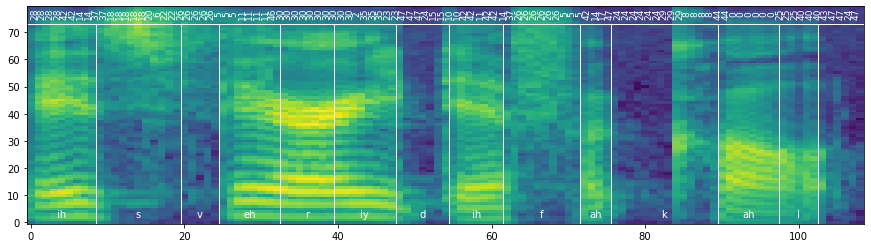

In [29]:
downsample_factor = 1

for utt_key in utterances[1:]:
    features = audio_dict[utt_key].T
    indices = indices_dict[utt_key]
    phones = reference_interval_dict[utt_key]

    # Codes
    plt.figure(figsize=(15, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*downsample_factor + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)

    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utt_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

## Segmentation

In [65]:
# Segmentation
boundaries_dict = {}
code_indices_dict = {}
for utt_key in utterances[:1]:
    
    # Segment
    z = z_dict[utt_key]
    boundaries, code_indices = dp_penalized(embedding, z, dur_weight=3)
#     boundaries, code_indices = l2_segmentation(embedding, z, dur_weight=25**2)
#     boundaries, code_indices = l2_n_segments(embedding, z, n_frames_per_segment=7, n_max_frames=z.shape[0])
#     boundaries, code_indices = benji_l2_n_segments(embedding, z, n_frames_per_segment=7)

#     print(code_indices)
#     print(len(boundaries))

    # Convert boundaries to same frequency as reference
    if downsample_factor > 1:
        boundaries_upsampled = np.zeros(
            len(boundaries)*downsample_factor, dtype=bool
            )
        for i, bound in enumerate(boundaries):
            boundaries_upsampled[i*downsample_factor + 1] = bound
        boundaries = boundaries_upsampled

        code_indices_upsampled = []
        for start, end, index in code_indices:
            code_indices_upsampled.append((
                start*downsample_factor, 
                end*downsample_factor,
                index
                ))
        code_indices = code_indices_upsampled

    boundaries_dict[utt_key] = boundaries
    code_indices_dict[utt_key] = code_indices

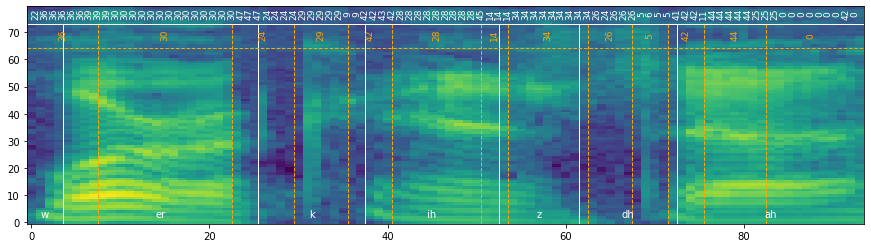

In [66]:
for utt_key in utterances[:1]:
    features = audio_dict[utt_key].T
    indices = indices_dict[utt_key]
    phones = reference_interval_dict[utt_key]

    # Codes
    plt.figure(figsize=(15, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*downsample_factor + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)

    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utt_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

    # Segmentation
    c = "orange"
    for start, end, label in code_indices_dict[utt_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, features.shape[0] - 11, label, color=c, va="center", ha="center", rotation=90, size=9)
    plt.vlines(
        np.where(boundaries_dict[utt_key][:-1])[0] + 0.5, ymin=-0.5, ymax=features.shape[0] - 7, colors=c, lw=1, linestyles="dashed"
        )  # predicted boundaries
    plt.hlines(features.shape[0] - 16, -0.5, features.shape[1] - 0.5, colors=c, lw=1, linestyles="dashed")
    

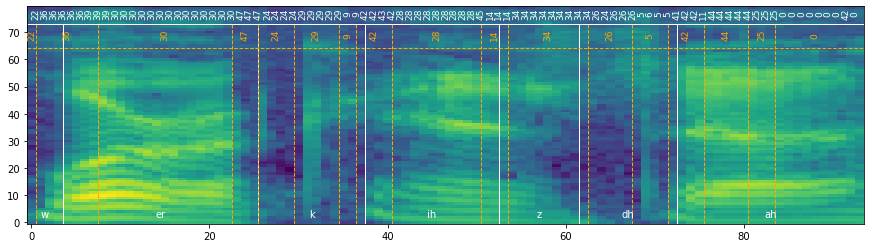

In [64]:
for utt_key in utterances[:1]:
    features = audio_dict[utt_key].T
    indices = indices_dict[utt_key]
    phones = reference_interval_dict[utt_key]

    # Codes
    plt.figure(figsize=(15, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*downsample_factor + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)

    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utt_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

    # Segmentation
    c = "orange"
    for start, end, label in code_indices_dict[utt_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, features.shape[0] - 11, label, color=c, va="center", ha="center", rotation=90, size=9)
    plt.vlines(
        np.where(boundaries_dict[utt_key][:-1])[0] + 0.5, ymin=-0.5, ymax=features.shape[0] - 7, colors=c, lw=1, linestyles="dashed"
        )  # predicted boundaries
    plt.hlines(features.shape[0] - 16, -0.5, features.shape[1] - 0.5, colors=c, lw=1, linestyles="dashed")
    